# Compute steric sea level change in the North East Atlantic using EN4 data set and gsw package

In [3]:
#import netCDF4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
#import gsw
from scipy import signal
import importlib
import sys
sys.path.append('../code')
import SeaLevelContrib as slc

In [36]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [34]:
data_path = '../data/DataDensity/'
data_EN4 = data_path + 'density_teos10_EN421f_analysis_g10/'

In [12]:
def pearson_r_3D(ts,slab,anom=True):
    """
    Compute a 2D field of correlation coefficients,
    given a 1D-timeseries ('ts') and a 3D-field ('slab')
    """
    # compute anomalies if neccessary
    if not anom:
        ts = ts - np.nanmean(ts)
        slab = slab - np.expand_dims(np.nanmean(slab,axis=0),0)
    # 'ts' to match 3D shape of 'slab'
    ts_3D = np.rollaxis(np.rollaxis(np.reshape(
        np.tile(ts,slab.shape[1]*slab.shape[2]), 
        (slab.shape[2],slab.shape[1],len(ts))),2,0),2,1)
    # standard deviations
    ts_3D_slab_cov = np.nansum(ts_3D*slab,axis=0)
    ts_3D_stdev = np.sqrt(np.nansum(np.power(ts_3D,2),axis=0))
    slab_stdev = np.sqrt(np.nansum(np.power(slab,2),axis=0))
    # pearson correlation
    pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)
    # done
    return pearson

### Explore the EN4 data over different integration depths and reference periods

Coordinates:
  * depth    (depth) float32 5.0215898 15.07854 25.16046 ... 5050.9897 5350.272
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2014 2015 2016 2017 2018


/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, '')

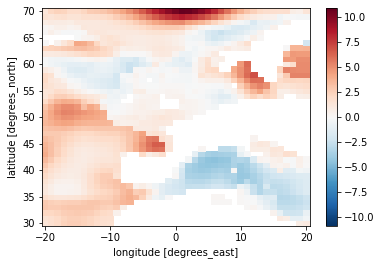

In [14]:
DENS = xr.open_dataset(data_EN4 +'density_teos10_en4_1900_2019.nc')
print(DENS.coords)
midp = (np.array(DENS.depth[1:])+np.array(DENS.depth[:-1]))/2
midp = np.insert(midp, 0, np.array([0]))
midp = np.insert(midp, len(midp), np.array(DENS.depth[-1]) + 
                 (np.array(DENS.depth[-1]) - np.array(DENS.depth[-2])))
thick = midp[1:] - midp[:-1]
thick = xr.DataArray(thick, coords={'depth': DENS.depth[:]}, dims='depth')

SumDens = DENS.density * thick
# Steric sea level in cm
StericSL = (- SumDens.sel(depth=slice(0,2000)).sum(dim='depth') 
            / DENS.density[0 ,0 ,: ,:]) * 100
StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
StericSL.sel(time=slice(2000,2018)).mean(dim='time').plot()
plt.title('')

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


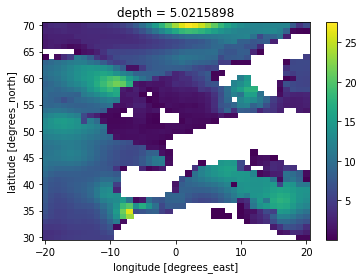

In [16]:
StericSLVar = StericSL.var(dim='time')
StericSLVar.plot()

### Check the correlation between tide gauge time series and steric sea level

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


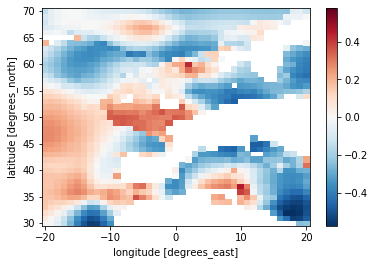

In [49]:
# Newlyn: 202, Brest: 1, Vlissingen: 20, Hoek van Holland:22
SeaLevel_df = slc.tide_gauge_obs([22], interp = True)
SeaLevel_df.rename(columns={'Average' : 'height'}, inplace=True)

# Compute the correlation of the detrended data set, with a running mean of 2 years
StericSL_noNaN = xr.where(np.isnan(StericSL), 0, StericSL)
# StericSLcor_dt = pearson_r_3D( signal.detrend( SeaLevel_df.height[SeaLevel_df.index >= 1993]), 
#                            signal.detrend( StericSL_noNaN.sel( time=slice( 1993, 2017)), axis=0), anom=False)
StericSLcor_dt = pearson_r_3D( signal.detrend( SeaLevel_df.height.loc[1950:1980].rolling(2).mean().dropna() ), 
                              signal.detrend( StericSL_noNaN.sel( time=slice( 1950, 1980)).rolling(time=2).mean().dropna('time'), axis=0)
                              , anom=False)
StericSLcor_dt = xr.DataArray(StericSLcor_dt, dims=['lat', 'lon'], 
                           coords={'lat' : StericSL.lat, 'lon' : StericSL.lon})
StericSLcor_dt.plot()

The result depends a lot on the choice of the tide gauge even for the Dutch coast. Compare for example Vlissingen and Hoek van Holland.

### Define a few region masks over which the steric effect is computed.

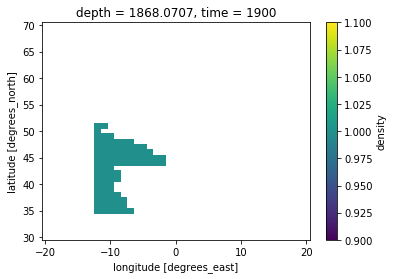

In [26]:
mask = xr.where(np.isnan(DENS.density[0,:,:,:].sel(depth=2000, method='nearest')), np.NaN, 1)
mask = mask.where(mask.lon <= -2)
mask = mask.where(mask.lon >= -12)
mask = mask.where(mask.lat <= 52)
mask = mask.where(mask.lat >= 35)
mask.plot()


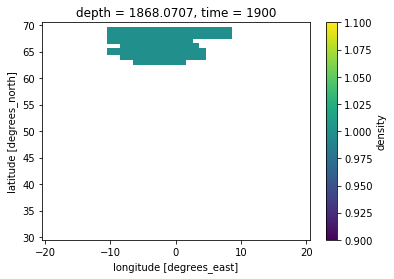

In [27]:
mask2 = xr.where(np.isnan(DENS.density[0,:,:,:].sel(depth=2000, method='nearest')), np.NaN, 1)
mask2 = mask2.where(mask2.lon <= 8)
mask2 = mask2.where(mask2.lon >= -10)
mask2 = mask2.where(mask2.lat <= 69)
mask2 = mask2.where(mask2.lat >= 60)
mask2.plot()

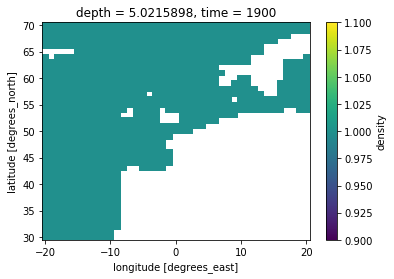

In [28]:
lat = np.array(DENS.lat)
lon = np.array(DENS.lon)
LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                     coords={'lat' : lat, 'lon' : lon})
LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                     coords={'lat' : lat, 'lon' : lon})

mask_med = xr.where(np.isnan(DENS.density[0,0,:,:]), np.NaN, 1)
mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
mask_med = mask_med * mask_med1 * mask_med2
mask_med.plot()

#(LonAr >= 0) & (LatAr >= 60)

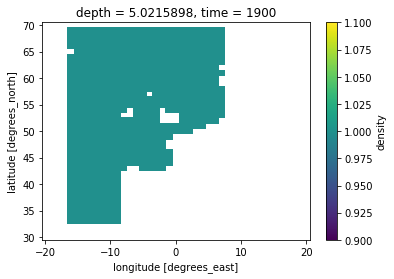

In [29]:
mask3 = xr.where(np.isnan(DENS.density[0,0,:,:]), np.NaN, 1)
mask3 = mask3.where(mask3.lon <= 7)
mask3 = mask3.where(mask3.lon >= -16)
mask3 = mask3.where(mask3.lat <= 69) #Normal value: 60
mask3 = mask3.where(mask3.lat >= 33)
mask3 = mask3 * mask_med
mask3.plot()

### Compare steric sea level in the different regions

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


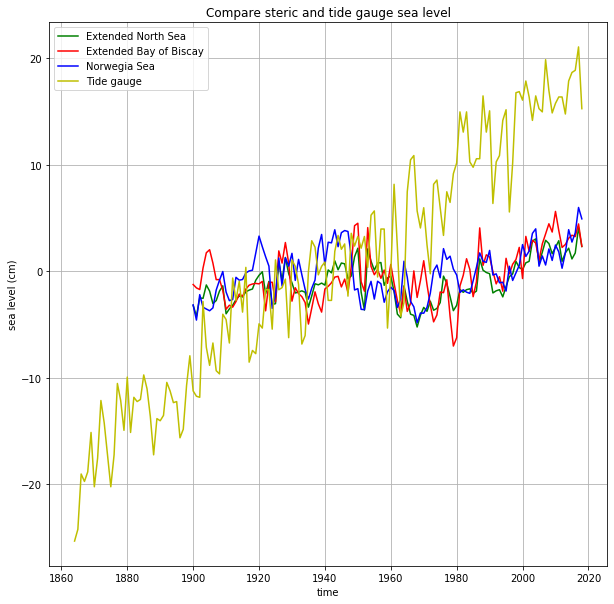

In [50]:
max_depth = 2000
StericSL_ENS_df = slc.StericSL_EN4(max_depth,'ENS')
StericSL_EBB_df = slc.StericSL_EN4(max_depth,'EBB')
StericSL_NWS_df = slc.StericSL_EN4(max_depth,'NWS')

#Plot time series
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(StericSL_ENS_df, 'g-', label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', label='Norwegia Sea')
ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric and tide gauge sea level')
ax.grid(True)
plt.legend(loc='upper left')

### Compare with the global mean steric sea level anomaly from NOAA, Levitus

In [51]:
#Global mean total sea level anomaly (NOAA, Levitus)
LevitusSL_df = slc.LevitusSL()
LevitusSL_NA_df = slc.LevitusSL('NA')
#LevitusSL_df

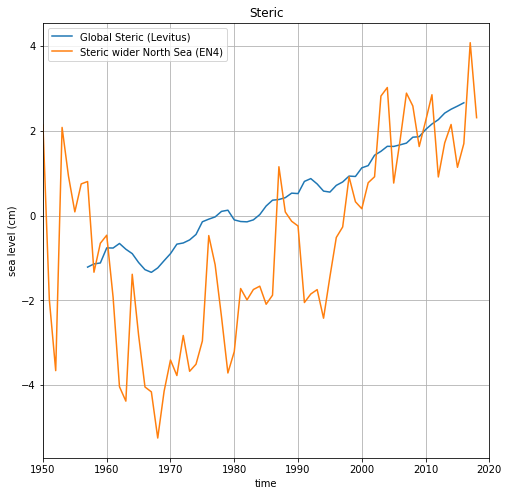

In [53]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(SeaLevel_df.height, 'r-') #From mm to cm
#ax.plot(StericSL_NS_df, 'b-')
ax.plot(LevitusSL_df, label='Global Steric (Levitus)')
#ax.plot(LevitusSL_NA_df, label='North Atlantic Steric(Levitus)')
#ax.plot(StericSLreg_df, label='Steric Bay biscay (EN4)')
ax.plot(StericSL_ENS_df, label='Steric wider North Sea (EN4)')
#ax.set_aspect(1)
ax.set_xlim([1950,2020])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Steric')
plt.legend(loc='upper left')
ax.grid(True)

#plt.savefig('./Figures/ComparisonGloLocSteric', dpi=150)

### Compute the depth of the grid

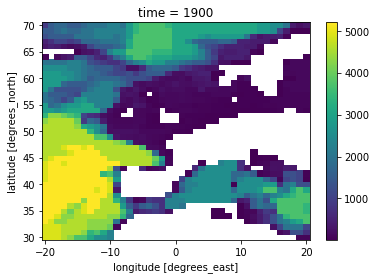

In [54]:
Ones = xr.where(np.isnan(DENS.density[0,:,:,:]), np.NaN, 1)
DepthAr = (Ones * thick).sum(axis=0)
DepthArSel = xr.where(DepthAr == 0, np.NaN, DepthAr)
DepthArSel = xr.where(DepthAr >= 6000, np.NaN, DepthArSel)
DepthArSel.plot()
#DepthAr.plot()

Idea: Use the same method as in Seltini et al. 2017? Average steric effect of deeper area to determine the local effect. For "surface" waters. Use a large area for deep water and an even larger area for bottom water.

### Compare Levitus pentad data that stop in 2016 with the yearly data that goes on to 2018

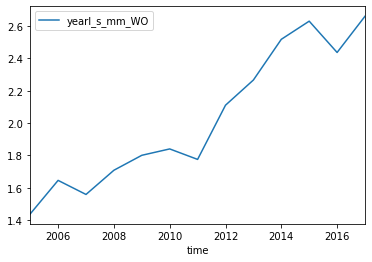

In [55]:
PATH_Data = '/Users/dewilebars/Data/'
Dir_LEV = PATH_Data + 'NOAA/'

Lev_ds = xr.open_dataset(Dir_LEV + \
                         'mean_total_steric_sea_level_anomaly_0-2000_yearly.nc', \
                         decode_times=False)
LevitusSL_y = Lev_ds.yearl_s_mm_WO.copy() / 10

# Convert from months since 1955 to years
LevitusSL_y['time'] = LevitusSL_y.time / 12 + 1955 - .5
LevitusSL_y['time'] = LevitusSL_y.time.astype(int)
LevitusSL_y_df = LevitusSL_y.to_dataframe()
LevitusSL_y_df.iloc[:-1].plot()
#LevitusSL_df.plot()

The yearly data only adds one year so it is not worth it.

In [43]:
Lev_ds_ext = slc.LevitusSL(extrap=True)
Lev_ds_ext

0.09619274139402238


,StericLevitus
time,
1957,-1.216563
1958,-1.141190
1959,-1.118930
1960,-0.763188
1961,-0.766074
1962,-0.658352
1963,-0.794159
1964,-0.898166
1965,-1.108180
